In [1]:
from openeye import oechem
import cmiles
import fragmenter
import oenotebook as oenb
import qcfractal.interface as portal
import json

In [2]:
smiles = 'OCCO'

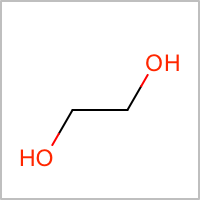

In [3]:
oenb.draw_smiles('C(CO)O')

In [4]:
mol_id = cmiles.to_molecule_id(smiles, strict=False)

In [5]:
mapped_smiles = mol_id['canonical_isomeric_explicit_hydrogen_mapped_smiles']

In [6]:
mapped_mol = fragmenter.chemi.smiles_to_oemol(mapped_smiles)
mol_conf = fragmenter.chemi.generate_conformers(mapped_mol, max_confs=1, strict_stereo=True)
qm_mol = cmiles.utils.mol_to_map_ordered_qcschema(mol_conf, mol_id)

CSS took 0.0009431838989257812 seconds
Match SMILES: [H:7][C:2]([H:8])([C:1]([H:5])([H:6])[O:3][H:9])[O:4][H:10]


In [7]:
# view conformation
atom_map = cmiles.utils.get_atom_map(mol_conf, mapped_smiles)
xyz = fragmenter.chemi.to_mapped_xyz(mol_conf, atom_map, xyz_format=True, filename='ethylene_glycol.xyz')

CSS took 4.00543212890625e-05 seconds
Match SMILES: [H:7][C:2]([H:8])([C:1]([H:5])([H:6])[O:3][H:9])[O:4][H:10]


In [8]:
# Generate torsiondrive input
torsions = fragmenter.torsions.find_torsions(mol_conf, restricted=False, terminal=False)

15:25:43 INFO fragmenter: List of torsion to drive:
15:25:43 INFO fragmenter: Idx: 3 1 2 4
15:25:43 INFO fragmenter: Atom numbers: 8 6 6 8


In [9]:
torsion_job = fragmenter.torsions.define_torsiondrive_jobs(torsions, internal_torsion_resolution=15)

In [10]:
to_qcfractal = {mapped_smiles:{'2_0_1_3': {'type': 'torsiondrive_input',
                                'initial_molecule': qm_mol,
                                'dihedrals': torsion_job['crank_job_0']['dihedrals'],
                                'grid_spacing': torsion_job['crank_job_0']['grid_spacing']}}}

In [11]:
with open('workflow.json', 'r') as f:
    json_workflow = json.load(f)
rdkit = json_workflow['torsiondrive_rdkit']
psi4 = json_workflow['torsiondrive_psi4']

In [14]:
client = portal.FractalClient('https://localhost:7777/', verify=False)
off_workflow = portal.collections.OpenFFWorkflow('torsiondrive_rdkit', client, **rdkit)

In [17]:
off_workflow.add_fragment(mapped_smiles, to_qcfractal[mapped_smiles])

In [34]:
client.list_collections()

{'openffworkflow': ['torsiondrive_rdkit', 'torsiondrive_rdkit_2']}

In [20]:
# add psi4 collection
psi4_workflow = portal.collections.OpenFFWorkflow('torsiondrive_psi4', client, **psi4)

In [21]:
psi4_workflow.get_options('optimization_static_options')

{'optimization_meta': {'program': 'geometric', 'coordsys': 'tric'},
 'qc_meta': {'driver': 'gradient',
  'method': 'B3LYP-D3',
  'basis': 'def2-svp',
  'options': None,
  'program': 'psi4'}}

In [22]:
psi4_workflow.add_fragment(mapped_smiles, to_qcfractal[mapped_smiles])

In [35]:
def _serialize_key(key):
    if isinstance(key, (int, float)):
        key = (int(key), )
    return json.dumps(key)

def serialize(final_json):
    serialized_dict = {}
    for frag in final_json:
        serialized_dict[frag] = {}
        for job in final_json[frag]:
            serialized_dict[frag][job] = {}
            for key in final_json[frag][job]:
                value = final_json[frag][job][key]
                new_key = _serialize_key(key)
                serialized_dict[frag][job][new_key] = value
    return serialized_dict

In [36]:
# save molecules and energies
# serialize
serialized_energies = serialize(psi4_workflow.list_final_energies())
serialized_molecules = serialize(psi4_workflow.list_final_molecules())
    
with open('psi4_final_energies.json', 'w') as f:
    json.dump(serialized_energies, f, indent=2, sort_keys=True)
with open('psi4_final_molecules.json', 'w') as f:
    json.dump(serialized_molecules, f, indent=2, sort_keys=True)